In [1]:
!pip install hypertools

In [2]:
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../'))
from timecorr.timecorr import levelup, timepoint_decoder
import matplotlib.pyplot as plt
from math import log

sliding_window_length = 51
block_length = 1
covariance_num = 300
noise_level = [0.01,0.1,1,10]
repetitions=100
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
level_num = 10
subject_num = 6
activation_num = 5

activations = [[np.random.normal(0,1,[activation_num, time_len]) for i in range(subject_num)] for j in range(noise_num)]
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(noise_num):
        activations[i]=[(activations_temp+np.random.normal(0,noise_level[i],[activation_num, time_len])).T for s in range(subject_num)]

decoding_accuracy, decoding_rank, decoding_error = np.zeros([noise_num, level_num]),np.zeros([noise_num, level_num]),np.zeros([noise_num, level_num])
for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for l in range(level_num):
        for n in range(noise_num):
            activations[n] = levelup(activations[n],"within")
            results = timepoint_decoder(activations[n],nfolds=3)
            decoding_accuracy[n,l]+=results['accuracy']
decoding_accuracy/=repetitions

{'accuracy': 0.87555555555555564, 'rank': 0.99939259259259305, 'error': 0.00053511705685618707}
{'accuracy': 0.12111111111111111, 'rank': 0.97654444444444544, 'error': 0.014139725009290291}
{'accuracy': 0.0022222222222222222, 'rank': 0.56406296296296299, 'error': 0.27742474916387955}
{'accuracy': 0.0022222222222222222, 'rank': 0.5392407407407408, 'error': 0.41346711259754737}
{'accuracy': 0.6677777777777778, 'rank': 0.99734074074074142, 'error': 0.0017725752508361194}
{'accuracy': 0.08111111111111112, 'rank': 0.95646296296296507, 'error': 0.089219620958751134}
{'accuracy': 0.0055555555555555558, 'rank': 0.62188888888888905, 'error': 0.31806763285024164}
{'accuracy': 0.0033333333333333335, 'rank': 0.468911111111111, 'error': 0.307487922705314}
{'accuracy': 0.47444444444444445, 'rank': 0.99389629629629772, 'error': 0.0034894091415830532}
{'accuracy': 0.035555555555555556, 'rank': 0.88472592592592658, 'error': 0.064310665180230417}
{'accuracy': 0.0011111111111111111, 'rank': 0.47918888888

In [35]:
import numpy as np
decoding_accuracy=np.array([[0.99959037,0.99841678,0.99666744,0.99393081,0.98799059,0.9766147,0.96091681,0.94175433,0.90457041,0.863937],[0.98344711,0.97096493,0.94638507,0.90449226,0.83736481,0.77095552, 0.68761619,0.61863878,0.57505619,0.53926304],[0.60204993,0.50246048,0.49407704,0.50164896,0.50633081,0.49559059, 0.50237633,0.50766111,0.50382204,0.49468981],[0.50833926,0.49337985,0.49805852,0.50135726,0.491788,0.49667493, 0.50914326,0.50365296,0.49207593,0.50457922]])
decoding_rank = np.array([[0.99959037, 0.99841678, 0.99666744, 0.99393081, 0.98799059, 0.9766147, 0.96091681, 0.94175433, 0.90457041, 0.863937], [0.98344711, 0.97096493, 0.94638507, 0.90449226, 0.83736481, 0.77095552, 0.68761619, 0.61863878, 0.57505619, 0.53926304], [0.60204993, 0.50246048, 0.49407704, 0.50164896, 0.50633081, 0.49559059, 0.50237633, 0.50766111, 0.50382204, 0.49468981], [0.50833926, 0.49337985, 0.49805852, 0.50135726, 0.491788, 0.49667493, 0.50914326, 0.50365296, 0.49207593, 0.50457922]])
decoding_error = np.array([[0.0003712,0.00114084,0.00215741,0.00380264,0.00676659,0.01807715,0.02746184,0.04468807,0.07030531,0.09870884],[0.01043263,0.02110238,0.0427647,0.07614359,0.11691364,0.16458997,0.22246499,0.26355864,0.28116748,0.31020409],[0.29388075,0.33556462,0.34893679,0.34017886,0.34864708,0.35523891,0.34702969,0.33590268,0.34231479,0.341923],[ 0.341445,0.34111275,0.34901787,0.34076997,0.35221929,0.34481148,0.33721022,0.3410249,0.34190145,0.33599922]])

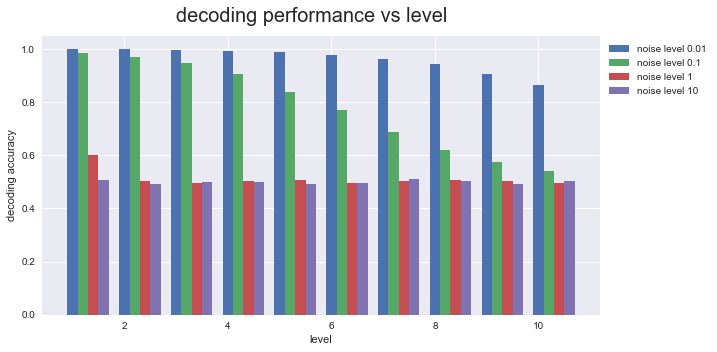

In [39]:
import matplotlib.pyplot as plt
noise_level = [0.01,0.1,1,10]
noise_num = len(noise_level)
f, a1 = plt.subplots(1,1, figsize=(10,5))
plt.subplots_adjust(top=0.9)
plt.suptitle("decoding performance vs level",fontsize=20)
a1.set_ylabel("decoding accuracy")

for v in range(noise_num): 
    a1.bar(np.arange(1,11)+v*0.2,decoding_accuracy[v],0.2,color='C'+str(v),alpha=1,linestyle='-', label="noise level "+str(noise_level[v]))
    
a1.set_xlabel("level")
a1.legend(bbox_to_anchor=(1, 1), loc=0)
f.subplots_adjust(hspace=0.3)
plt.show()

In [3]:
import numpy as np
from scipy.linalg import cholesky
from scipy.spatial.distance import squareform
from scipy.stats.stats import pearsonr
import sys
import os
sys.path.append(os.path.abspath('../'))
from timecorr.timecorr import levelup, timepoint_decoder
import matplotlib.pyplot as plt
from math import log

sliding_window_length = 51
block_length = 1
covariance_num = 300
noise_level = [0,0.01,0.1,1,10]
repetitions=1
noise_num = len(noise_level)
time_range=time_len = block_length * covariance_num
level_num = 10
subject_num = 6
activation_num = 5

activations = [[np.random.normal(0,1,[activation_num, time_len]) for i in range(subject_num)] for j in range(noise_num)]
correlations = np.zeros([covariance_num,activation_num,activation_num])
correlation1,correlation2 = np.zeros([activation_num,activation_num]), np.zeros([activation_num,activation_num])


def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

def cholesky_ramp_correlation_data():
    global activations, correlations,correlation1,correlation2
    correlations = np.zeros([covariance_num,activation_num,activation_num])
    activations_temp = np.random.normal(0,1,[activation_num, time_len])
    
    while not is_pos_def(correlation1):
        feature_map1 = np.random.normal(0,1,[activation_num,activation_num])
        correlation1 = np.dot(feature_map1,feature_map1.T)
        correlation1 = correlation1/np.max(abs(correlation1))
    while not is_pos_def(correlation2):
        feature_map2 = np.random.normal(0,1,[activation_num,activation_num])
        correlation2 = np.dot(feature_map2,feature_map2.T)
        correlation2 = correlation2/np.max(abs(correlation2))
    for i in range(time_len):
        cov_temp = (time_len-i)*0.5*(np.log(1+correlation1+1e-5) - np.log(1-correlation1+1e-5))/float(time_len)+i*0.5*(np.log(1+correlation2+1e-5) - np.log(1-correlation2+1e-5))/float(time_len)
        correlations[i] =  (np.exp(2*cov_temp) - 1)/(np.exp(2*cov_temp) + 1)
        activations_temp[:,i] = np.dot(cholesky(correlations[i]),activations_temp[:,i])
    for i in range(noise_num):
        activations[i]=[(activations_temp+np.random.normal(0,noise_level[i],[activation_num, time_len])).T for s in range(subject_num)]

decoding_accuracy = np.zeros([noise_num, level_num])
for i in range(repetitions):
    cholesky_ramp_correlation_data()
    for l in range(level_num):
        for n in range(noise_num):
            if l>0:
                activations[n] = levelup(activations[n],"within")
            results = timepoint_decoder(activations[n],nfolds=10)
            decoding_accuracy[n,l]+=results
decoding_accuracy/=repetitions


In [4]:
print(decoding_accuracy)

[[  1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00   1.00000000e+00   1.00000000e+00
    1.00000000e+00   1.00000000e+00]
 [  1.00000000e+00   9.50333333e-01   9.09666667e-01   7.76000000e-01
    6.36000000e-01   5.01000000e-01   3.63000000e-01   2.99000000e-01
    3.29000000e-01   1.72666667e-01]
 [  8.78333333e-01   3.17000000e-01   2.01666667e-01   2.14666667e-01
    1.58000000e-01   8.23333333e-02   4.53333333e-02   1.60000000e-02
    1.06666667e-02   8.66666667e-03]
 [  3.73333333e-02   4.33333333e-03   5.66666667e-03   3.00000000e-03
    5.00000000e-03   5.33333333e-03   2.66666667e-03   3.33333333e-03
    3.33333333e-04   2.33333333e-03]
 [  1.66666667e-03   2.66666667e-03   2.00000000e-03   3.00000000e-03
    6.00000000e-03   4.33333333e-03   1.00000000e-03   2.33333333e-03
    3.00000000e-03   3.33333333e-03]]


In [ ]:
import matplotlib.pyplot as plt
noise_level = [0,0.01,0.1,1,10]
noise_num = len(noise_level)
f, a1 = plt.subplots(1,1, figsize=(10,5))
plt.subplots_adjust(top=0.9)
plt.suptitle("decoding performance vs level",fontsize=20)
a1.set_ylabel("decoding accuracy")

for v in range(noise_num): 
    a1.bar(np.arange(1,11)+v*0.2,decoding_accuracy[v],0.2,color='C'+str(v),alpha=1,linestyle='-', label="noise level "+str(noise_level[v]))
    
a1.set_xlabel("level")
a1.legend(bbox_to_anchor=(1, 1), loc=0)
f.subplots_adjust(hspace=0.3)
plt.show()